# Quantum vs Classical on Tiny Datasets

Goal: compare simple classical models (Logistic Regression, SVC) against a small quantum variational classifier (Qiskit) on low-dimensional synthetic datasets. We keep everything 2D so we can map 2 features → 2 qubits.

# Imports

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles, make_blobs, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Make tiny datasets

In [30]:
def build_datasets(random_state=42, test_size=0.3):
    datasets = {}

    # 1) Easy, almost linearly separable blobs
    X_blobs, y_blobs = make_blobs(
        n_samples=200,
        centers=2,
        n_features=2,
        cluster_std=1.0,
        random_state=random_state,
    )
    datasets["blobs"] = (X_blobs, y_blobs)

    # 2) Concentric circles (non-linear, classic example)
    X_circ, y_circ = make_circles(
        n_samples=200,
        factor=0.5,
        noise=0.05,
        random_state=random_state,
    )
    datasets["circles"] = (X_circ, y_circ)

    # 3) XOR-ish dataset using make_classification
    # we make 2 informative features, no redundancy
    X_xor, y_xor = make_classification(
        n_samples=200,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=random_state,
    )
    datasets["classification"] = (X_xor, y_xor)

    return datasets

# Visualize to confirm

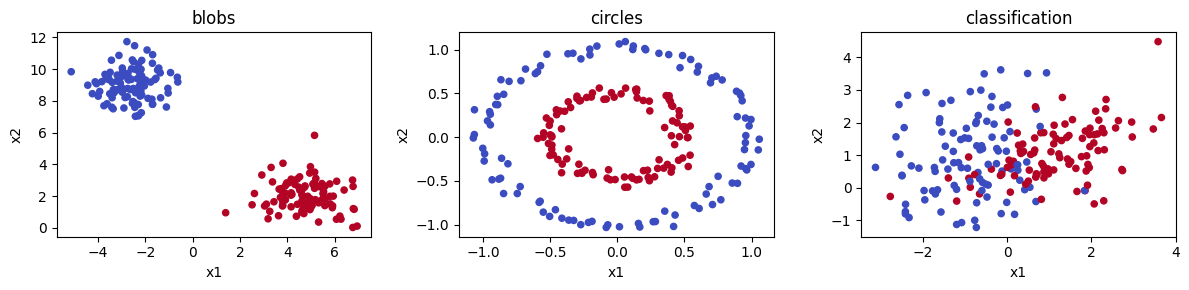

In [31]:
datasets = build_datasets()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, (name, (X, y)) in zip(axes, datasets.items()):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=20)
    ax.set_title(name)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

# Scaling helper

In [32]:
def train_test_scaled(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [33]:
import time
from sklearn.metrics import accuracy_score

# Helper to train one classical model

In [34]:
def run_classical_models_on_dataset(name, X, y):
    """
    Trains Logistic Regression and SVC (RBF) on a single dataset.
    Returns a list of dicts with results.
    """
    X_train, X_test, y_train, y_test, scaler = train_test_scaled(X, y)

    results = []

    # 1) Logistic Regression
    start = time.time()
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    end = time.time()

    results.append({
        "dataset": name,
        "model": "LogisticRegression",
        "accuracy": acc,
        "train_time_sec": end - start,
    })

    # 2) SVC with RBF kernel
    start = time.time()
    svc = SVC(kernel="rbf", gamma="scale")
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    end = time.time()

    results.append({
        "dataset": name,
        "model": "SVC_RBF",
        "accuracy": acc,
        "train_time_sec": end - start,
    })

    return results

# Loop over all datasets

In [35]:
all_results = []

for ds_name, (X, y) in datasets.items():
    ds_results = run_classical_models_on_dataset(ds_name, X, y)
    all_results.extend(ds_results)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by=["dataset", "model"]).reset_index(drop=True)
results_df

,dataset,model,accuracy,train_time_sec
0,blobs,LogisticRegression,1.000000,0.028653
1,blobs,SVC_RBF,1.000000,0.011481
2,circles,LogisticRegression,0.466667,0.003569
3,circles,SVC_RBF,1.000000,0.003165
4,classification,LogisticRegression,0.866667,0.003457
5,classification,SVC_RBF,0.900000,0.003767


# Quantum imports

In [36]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import Aer
from qiskit_machine_learning.algorithms import QSVC
from qiskit import QuantumCircuit, transpile

In [37]:
from sklearn.model_selection import train_test_split

def train_test_minmax_pi(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    x_min = X_train.min(axis=0)
    x_max = X_train.max(axis=0)
    denom = np.where((x_max - x_min) == 0, 1, (x_max - x_min))

    def to_pi(x):
        normed = (x - x_min) / denom
        return normed * np.pi

    X_train_pi = to_pi(X_train)
    X_test_pi = to_pi(X_test)

    return X_train_pi, X_test_pi, y_train, y_test

# Subsample helper for quantum

In [38]:
def get_small_split(X, y, n_train=40, n_test=20, random_state=42):
    rng = np.random.default_rng(random_state)
    idx = rng.permutation(len(X))[: (n_train + n_test)]
    X_small = X[idx]
    y_small = y[idx]

    X_train = X_small[:n_train]
    y_train = y_small[:n_train]
    X_test = X_small[n_train:n_train + n_test]
    y_test = y_small[n_train:n_train + n_test]
    return X_train, X_test, y_train, y_test

# Function to compute ONE kernel entry

In [39]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

backend = Aer.get_backend("statevector_simulator")

def kernel_entry(x, z, feature_map, backend=backend):
    """
    Compute K(x, z) = |<0...0| U(x)† U(z) |0...0>|^2
    where U is the feature map.
    """
    num_qubits = feature_map.num_qubits

    # U(z)
    circ_z = feature_map.assign_parameters(z)
    # U(x)†
    circ_x_dag = feature_map.assign_parameters(x).inverse()

    qc = QuantumCircuit(num_qubits)
    qc.compose(circ_x_dag, inplace=True)
    qc.compose(circ_z, inplace=True)

    # ❌ no qc.save_statevector() here

    tqc = transpile(qc, backend)
    result = backend.run(tqc).result()
    statevector = result.get_statevector()

    # amplitude of |00...0>
    value = abs(statevector[0]) ** 2
    return value

# Build full kernel matrices

In [40]:
def build_kernel_matrix(X1, X2, feature_map):
    """
    Build kernel matrix K where K[i, j] = K(X1[i], X2[j]).
    X1: shape (n1, d)
    X2: shape (n2, d)
    """
    n1 = len(X1)
    n2 = len(X2)
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = kernel_entry(X1[i], X2[j], feature_map)
    return K

# Now the “run quantum SVC on dataset” function

In [41]:
from sklearn.svm import SVC

def run_quantum_svc_on_dataset(name, X, y):
    """
    Quantum-kernel SVC using a hand-built kernel matrix.
    We do it on a small subset to keep it fast.
    """
    # 1) scale to [0, pi]
    X_pi_train_full, X_pi_test_full, y_train_full, y_test_full = train_test_minmax_pi(X, y)

    # 2) take a small subset for quantum
    X_train, X_test, y_train, y_test = get_small_split(
        X_pi_train_full, y_train_full,
        n_train=40, n_test=20
    )

    # 3) feature map
    feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

    # 4) build kernels
    K_train = build_kernel_matrix(X_train, X_train, feature_map)
    K_test = build_kernel_matrix(X_test, X_train, feature_map)

    # 5) SVC with precomputed kernel
    start = time.time()
    qs = SVC(kernel="precomputed")
    qs.fit(K_train, y_train)
    y_pred = qs.predict(K_test)
    acc = accuracy_score(y_test, y_pred)
    end = time.time()

    return {
        "dataset": name,
        "model": "QuantumSVC_manualKernel",
        "accuracy": acc,
        "train_time_sec": end - start,
        "n_train_q": len(X_train),
        "n_test_q": len(X_test),
    }

# Run it over all datasets and merge

In [42]:
q_results = []
for ds_name, (X, y) in datasets.items():
    res = run_quantum_svc_on_dataset(ds_name, X, y)
    q_results.append(res)

q_results_df = pd.DataFrame(q_results)
q_results_df

,dataset,model,accuracy,train_time_sec,n_train_q,n_test_q
0,blobs,QuantumSVC_manualKernel,0.95,0.009001,40,20
1,circles,QuantumSVC_manualKernel,0.65,0.003191,40,20
2,classification,QuantumSVC_manualKernel,0.65,0.004578,40,20


In [43]:
full_results_df = pd.concat([results_df, q_results_df], ignore_index=True)
full_results_df = full_results_df.sort_values(by=["dataset", "model"]).reset_index(drop=True)
full_results_df

,dataset,model,accuracy,train_time_sec,n_train_q,n_test_q
0,blobs,LogisticRegression,1.000000,0.028653,NaN,NaN
1,blobs,QuantumSVC_manualKernel,0.950000,0.009001,40.0,20.0
2,blobs,SVC_RBF,1.000000,0.011481,NaN,NaN
3,circles,LogisticRegression,0.466667,0.003569,NaN,NaN
4,circles,QuantumSVC_manualKernel,0.650000,0.003191,40.0,20.0
5,circles,SVC_RBF,1.000000,0.003165,NaN,NaN
6,classification,LogisticRegression,0.866667,0.003457,NaN,NaN
7,classification,QuantumSVC_manualKernel,0.650000,0.004578,40.0,20.0
8,classification,SVC_RBF,0.900000,0.003767,NaN,NaN
